# Classification Model Bake-off
- The goal is to create a that best predicts whether or not a person will default on their bank loan. 
- In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 
- You will fit **three different models** (KNN, Logistic Regression, and Decision Tree Classifier) to predict credit card defaults 
- Use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  
- We will be scoring the submitted predictions using the **F1 score.**

## Process/Expectations

1. Clean up your data set so that you can perform an EDA. 
    - This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Engineer new features. 
    - Create polynomial and/or interaction features. 
    - Additionaly, you must also create **at least 2 new features** that are not interactions or polynomial transformations. 
        - *For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.*
4. Perform some feature selection. 
5. You must fit **three** models to your data and tune **at least 1 hyperparameter** per model. 
6. Using the F-1 Score, evaluate how well your models perform and identify your best model.
7. Using information from your EDA process and your model(s) output provide insight as to which borrowers are more likely to deafult


In [50]:
# import libraries
import pandas as pd
pd.options.display.max_columns = 50
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV, SelectKBest, f_regression

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import pickle

## 1. Data Cleaning

In [51]:
df = pd.read_csv('training_data.csv', index_col=0)
# index_col=0 prevents generating that 'Unnamed:0' column

In [52]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


In [53]:
df.shape

(22500, 24)

In [54]:
# checking for missing values
# df.isna().sum()
# yay there's no null values

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

In [55]:
# making dataframe mor readable by creating new column names
rename_list = ["max_credit_given", "gender", "education", "marital_status", "age",
"pay_status_sept", "pay_status_aug", "pay_status_july", "pay_status_june", "pay_status_may", "pay_status_april", 
"bill_sept", "bill_aug", "bill_july", "bill_june", "bill_may", "bill_april",
"payment_sep", "payment_aug", "payments_jul", "payment_jun", "payment_may", "payment_apr", "default"]
col_rename = dict(zip(df.columns,rename_list))
df = df.rename(columns=col_rename)

In [56]:
# checking that it worked
df.head()

,max_credit_given,gender,education,marital_status,age,pay_status_sept,pay_status_aug,pay_status_july,pay_status_june,pay_status_may,pay_status_april,bill_sept,bill_aug,bill_july,bill_june,bill_may,bill_april,payment_sep,payment_aug,payments_jul,payment_jun,payment_may,payment_apr,default
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


In [58]:
df.iloc[18381]

max_credit_given                     LIMIT_BAL
gender                                     SEX
education                            EDUCATION
marital_status                        MARRIAGE
age                                        AGE
pay_status_sept                          PAY_0
pay_status_aug                           PAY_2
pay_status_july                          PAY_3
pay_status_june                          PAY_4
pay_status_may                           PAY_5
pay_status_april                         PAY_6
bill_sept                            BILL_AMT1
bill_aug                             BILL_AMT2
bill_july                            BILL_AMT3
bill_june                            BILL_AMT4
bill_may                             BILL_AMT5
bill_april                           BILL_AMT6
payment_sep                           PAY_AMT1
payment_aug                           PAY_AMT2
payments_jul                          PAY_AMT3
payment_jun                           PAY_AMT4
payment_may  

In [59]:
df.shape

(22500, 24)

In [60]:
# create a function that can remove this row if it has these values in the row
df.drop(df[df.gender == 'SEX'].index, inplace=True)

In [61]:
# checking that worked
df.shape

(22499, 24)

In [65]:
# Next deal with- why are there other educations besides 1-4 ??
df['education'].value_counts()

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: education, dtype: int64

- Next deal with- why are there other educations besides 1-4 ??
- After this, check for outliers in any other columns besides what they have been assigned in the description

## 2. EDA

In [ ]:
# check his example links for classification eda
# there's also examples in KNN lecture

## 3. Feature Engineering

## 4. Train-Test Split
### Preparing data for TTS

In [62]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('default', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = df['default'] # y is the column we're trying to predict

### Checking for class imbalance in 'default' column

In [63]:
df.default.value_counts()
# this means that there is a class imbalance!!

0    17471
1     5028
Name: default, dtype: int64

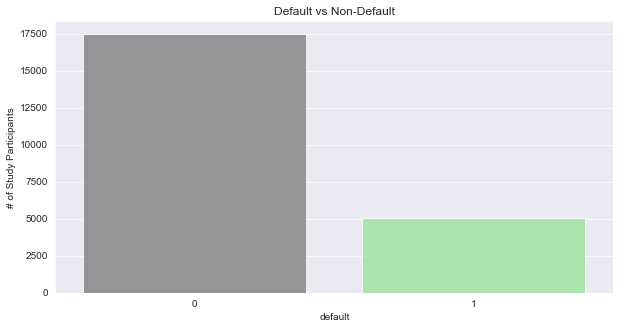

In [64]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Default vs Non-Default')
plt.ylabel('# of Study Participants')
plt.show()

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

### Feature Selection

## 6. Model Evaluation

## 7. Final Model